<a href="https://colab.research.google.com/github/johanjun/study_datascienceandpython/blob/main/oxford_pet(DenseNet%20%26%20test%20pred).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ref : https://github.com/jwlee-ml/mobis2021

In [45]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import xml.etree.ElementTree as et

In [46]:
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


# Data load

In [47]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:03, 248MB/s]


'oxford_pet.zip'

In [48]:
!ls -l

total 791584
drwx------ 5 root root      4096 Jul 19 04:48 drive
drwxr-xr-x 7 root root      4096 Jul 19 05:02 oxford_pet
-rw-r--r-- 1 root root 810565619 Jul 19 08:06 oxford_pet.zip
drwxr-xr-x 1 root root      4096 Jul 15 13:38 sample_data


In [49]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

replace oxford_pet/annotations/._trimaps? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [50]:
## directory 설정
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [51]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg'] #확장자 분리
print(len(image_files))

7378


In [ ]:
bbox_files = [fname for fname in os.listdir(bbox_dir) if os.path.splitext(fname)[-1] == '.xml']
print(len(bbox_files))

3686


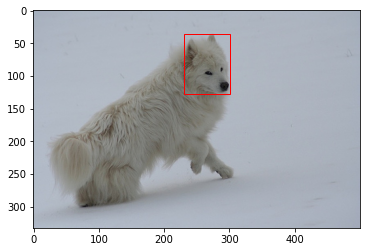

In [ ]:
#bbox 확인
rnd_idx = random.randint(1, len(image_files))
fname = image_files[rnd_idx]
fpath = os.path.join(image_dir, fname)
image = Image.open(fpath)
image = np.array(image)

bbox_name = os.path.splitext(fname)[0]+'.xml'
bbox_path = os.path.join(bbox_dir, bbox_name)
tree = et.parse(bbox_path)

width = float(tree.find('./size/width').text)
height = float(tree.find('./size/height').text)
xmin = float(tree.find('./object/bndbox/xmin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x, rect_y), rect_w, rect_h, fill=False, color='red')
plt.axes().add_patch(rect)
plt.imshow(image)
plt.show()

<function matplotlib.pyplot.show>

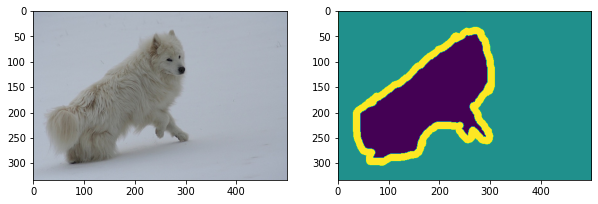

In [ ]:
#seg 확인
sname = os.path.splitext(fname)[0]+'.png'
spath = os.path.join(seg_dir, sname)
seg = Image.open(spath)
seg = np.array(seg)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(seg)
plt.show

In [9]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)

Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_139.jpg P
(250, 350)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_191.jpg P
(214, 300)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Abyssinian_34.jpg P
(202, 250)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Egyptian_Mau_145.jpg P
(188, 216)
Abyssinian_5.jpg RGBA
(150, 200, 4)


In [10]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [11]:
# class 생성
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [15]:
class_list.sort()
class_list

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [18]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [19]:
class2idx['Bengal']

1

In [20]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [21]:
image_files.sort()
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [22]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [23]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

print(len(train_images), len(val_images))

5920 1458


In [24]:
train_images[:10]

['boxer_182.jpg',
 'basset_hound_11.jpg',
 'basset_hound_27.jpg',
 'Persian_153.jpg',
 'keeshond_157.jpg',
 'japanese_chin_184.jpg',
 'wheaten_terrier_176.jpg',
 'miniature_pinscher_4.jpg',
 'shiba_inu_177.jpg',
 'Siamese_178.jpg']

In [25]:
val_images[:10]

['Ragdoll_86.jpg',
 'pug_9.jpg',
 'havanese_92.jpg',
 'shiba_inu_81.jpg',
 'japanese_chin_87.jpg',
 'american_bulldog_82.jpg',
 'shiba_inu_68.jpg',
 'samoyed_9.jpg',
 'wheaten_terrier_93.jpg',
 'wheaten_terrier_7.jpg']

# TFRecord File 만들기

In [26]:
IMG_SIZE = 224

In [27]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'cls_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'cls_val.tfr')

In [28]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [29]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [30]:
## Training data로 tfrecord 만들기
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(train_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

5920


In [31]:
## Validation data로 tfrecord 만들기
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(val_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print(n_val)

1458


# classification

In [32]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [33]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)

    return image, label

In [34]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [35]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH)

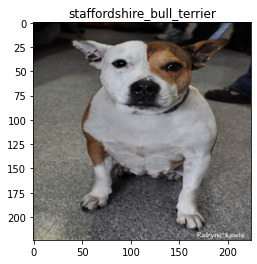

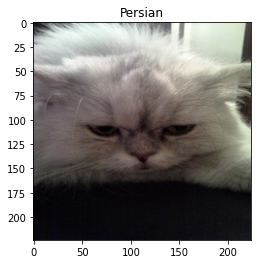

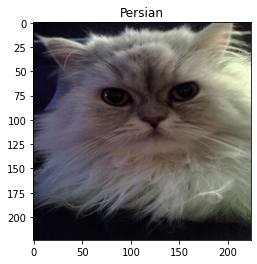

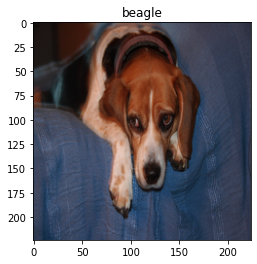

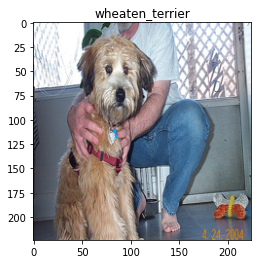

In [52]:
for image, label in train_dataset.take(5):
  plt.imshow(image[0])
  title = class_list[label[0].numpy()]
  plt.title(title)
  plt.show()

## modeling

In [37]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

In [38]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='sparse_categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       2

In [40]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 26s 53ms/step - loss: 3.5928 - accuracy: 0.0395 - val_loss: 3.4878 - val_accuracy: 0.0796
Epoch 2/20
148/148 [==============================] - 9s 50ms/step - loss: 3.3176 - accuracy: 0.1046 - val_loss: 3.1399 - val_accuracy: 0.1571
Epoch 3/20
148/148 [==============================] - 9s 50ms/step - loss: 3.0355 - accuracy: 0.1694 - val_loss: 2.9539 - val_accuracy: 0.1831
Epoch 4/20
148/148 [==============================] - 9s 50ms/step - loss: 2.8008 - accuracy: 0.2279 - val_loss: 2.8292 - val_accuracy: 0.2051
Epoch 5/20
148/148 [==============================] - 9s 50ms/step - loss: 2.5872 - accuracy: 0.2779 - val_loss: 2.7976 - val_accuracy: 0.2202
Epoch 6/20
148/148 [==============================] - 9s 49ms/step - loss: 2.3744 - accuracy: 0.3302 - val_loss: 2.6870 - val_accuracy: 0.2442
Epoch 7/20
148/148 [==============================] - 9s 49ms/step - loss: 2.1258 - accuracy: 0.3992 - val_loss: 2.7234 - val_accuracy: 0.244

In [42]:
# Sequential API를 사용하여 model 구성
def create_bn_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='SAME', 
                                  input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=256, kernel_size=3, padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    # model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(N_CLASS, activation='softmax'))
    return model

In [43]:
## Create model, compile & summary
model = create_bn_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 13s 70ms/step - loss: 3.1781 - accuracy: 0.1601 - val_loss: 4.8624 - val_accuracy: 0.0274
Epoch 2/20
148/148 [==============================] - 12s 68ms/step - loss: 1.6340 - accuracy: 0.5850 - val_loss: 5.7523 - val_accuracy: 0.0439
Epoch 3/20
148/148 [==============================] - 12s 68ms/step - loss: 0.6540 - accuracy: 0.9054 - val_loss: 3.7797 - val_accuracy: 0.1173
Epoch 4/20
148/148 [==============================] - 12s 68ms/step - loss: 0.1990 - accuracy: 0.9946 - val_loss: 2.9158 - val_accuracy: 0.2359
Epoch 5/20
148/148 [==============================] - 12s 68ms/step - loss: 0.0793 - accuracy: 0.9998 - val_loss: 2.7437 - val_accuracy: 0.2798
Epoch 6/20
148/148 [==============================] - 12s 68ms/step - loss: 0.0415 - accuracy: 1.0000 - val_loss: 2.6587 - val_accuracy: 0.2936
Epoch 7/20
148/148 [==============================] - 12s 68ms/step - loss: 0.0328 - accuracy: 1.0000 - val_loss: 2.6510 - val_accuracy:

# MobileNet

In [55]:
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D

In [56]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
mobilenetv2.summary()

In [58]:
def create_mv_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(N_CLASS, activation='softmax'))
  return model

In [59]:
## Create model, compile & summary
model = create_mv_model()

## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*5,
                                                          decay_rate=0.5,
                                                          staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps
)

Epoch 1/20
148/148 [==============================] - 38s 213ms/step - loss: 1.1673 - accuracy: 0.7125 - val_loss: 0.5719 - val_accuracy: 0.8100
Epoch 2/20
148/148 [==============================] - 32s 206ms/step - loss: 0.2370 - accuracy: 0.9389 - val_loss: 0.5642 - val_accuracy: 0.8100
Epoch 3/20
148/148 [==============================] - 32s 207ms/step - loss: 0.1057 - accuracy: 0.9777 - val_loss: 0.4635 - val_accuracy: 0.8416
Epoch 4/20
148/148 [==============================] - 32s 204ms/step - loss: 0.0486 - accuracy: 0.9941 - val_loss: 0.3689 - val_accuracy: 0.8724
Epoch 5/20
148/148 [==============================] - 32s 207ms/step - loss: 0.0257 - accuracy: 0.9988 - val_loss: 0.3357 - val_accuracy: 0.8909
Epoch 6/20
148/148 [==============================] - 32s 206ms/step - loss: 0.0166 - accuracy: 0.9995 - val_loss: 0.3092 - val_accuracy: 0.8964
Epoch 7/20
148/148 [==============================] - 32s 208ms/step - loss: 0.0133 - accuracy: 0.9992 - val_loss: 0.2939 - val_ac

# for Better model

In [61]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 50
N_BATCH = 40
N_TRAIN = n_train
N_VAL = n_val
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [72]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255. 

    label = tf.cast(parsed_features['cls_num'], tf.int64)
    label = tf.one_hot(label, N_CLASS)
    
    return image, label

In [80]:
#cutmix

def cutmix(images, labels, PROB=0.5):
  imgs = []; labs = []
  for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) <= PROB, tf.int32)
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

    W = IMG_SIZE; H = IMG_SIZE
    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam)
    cut_w = tf.cast(W * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(H * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(W/8), int(7/8*W), tf.int32)
    cy = tf.random.uniform((), int(H/8), int(7/8*H), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, W)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, H)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, W)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, H)

    mid_left = images[i, ymin:ymax, :xmin, :]
    mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1)
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]
    new_img = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_img)

    alpha = tf.cast((cut_w*cut_h)/(W*H), tf.float32)
    label1 = labels[i]; label2 = labels[idx]
    new_label = ((1-alpha)*label1 + alpha*label2)
    labs.append(new_label)

  new_imgs = tf.reshape(tf.stack(imgs), [-1, IMG_SIZE, IMG_SIZE, 3])
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])

  return new_imgs, new_labs

In [81]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(N_TRAIN).prefetch(tf.data.experimental.AUTOTUNE).batch(N_BATCH)
train_dataset = train_dataset.map(cutmix).repeat()

In [82]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

In [ ]:
for image, label in train_dataset.take(1):
  for i in range(N_BATCH):
    print(label[i].numpy())
    plt.imshow(image[i])
    plt.show()

In [84]:
def create_mv_model():
  model = models.Sequential()
  model.add(mobilenetv2)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dense(N_CLASS, activation='softmax'))
  return model

In [85]:
## Create model, compile & summary
model = create_mv_model()

## learning rate scheduing (cosine decay)

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
  if epoch < RAMPUP_EPOCH:
    lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
  else:
    lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
  return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_6 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 37)                9509      
Total params: 2,596,453
Trainable params: 2,561,829
Non-trainable params: 34,624
_______________________________________

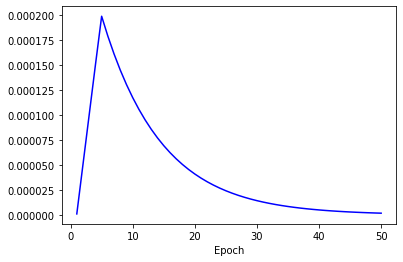

In [86]:
def plot_lr():
  lr = []
  epoch_list = list(np.arange(N_EPOCHS)+1)
  for epoch in range(N_EPOCHS):
    lr.append(lr_schedule_fn(epoch))
  plt.plot(epoch_list, lr, 'b-')
  plt.xlabel('Epoch')
  plt.show()

plot_lr()

In [87]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/50
148/148 [==============================] - 40s 227ms/step - loss: 3.9684 - accuracy: 0.0302 - val_loss: 3.7918 - val_accuracy: 0.0364
Epoch 2/50
148/148 [==============================] - 35s 223ms/step - loss: 2.1007 - accuracy: 0.6578 - val_loss: 1.0151 - val_accuracy: 0.9033
Epoch 3/50
148/148 [==============================] - 35s 223ms/step - loss: 1.5185 - accuracy: 0.8262 - val_loss: 1.0130 - val_accuracy: 0.9115
Epoch 4/50
148/148 [==============================] - 34s 222ms/step - loss: 1.4594 - accuracy: 0.8372 - val_loss: 1.0046 - val_accuracy: 0.9019
Epoch 5/50
148/148 [==============================] - 35s 224ms/step - loss: 1.4188 - accuracy: 0.8512 - val_loss: 1.1979 - val_accuracy: 0.8573
Epoch 6/50
148/148 [==============================] - 35s 225ms/step - loss: 1.4045 - accuracy: 0.8485 - val_loss: 1.0935 - val_accuracy: 0.8841
Epoch 7/50
148/148 [==============================] - 35s 222ms/step - loss: 1.3781 - accuracy: 0.8586 - val_loss: 1.1905 - val_ac

## Densenet

In [88]:
from tensorflow.keras.applications.densenet import DenseNet121

In [89]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

29089792/29084464 [==============================] - 0s 0us/step


In [90]:
def create_dense_model():
  model = models.Sequential()
  model.add(densenet)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(ReLU())
  model.add(Dense(N_CLASS, activation='softmax'))
  return model

In [91]:
## Create model, compile & summary
model = create_dense_model()

## learning rate scheduing (cosine decay)

LR_INIT = 0.000001
LR_MAX = 0.0002
LR_MIN = LR_INIT
RAMPUP_EPOCH = 4
EXP_DECAY = 0.9

def lr_schedule_fn(epoch):
  if epoch < RAMPUP_EPOCH:
    lr = (LR_MAX - LR_MIN) / RAMPUP_EPOCH * epoch + LR_INIT
  else:
    lr = (LR_MAX - LR_MIN) * EXP_DECAY**(epoch - RAMPUP_EPOCH)
  return lr

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule_fn)

model.compile(optimizer=tf.keras.optimizers.Adam(LR_INIT),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_7 (ReLU)               (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 37)                9509      
Total params: 7,310,437
Trainable params: 7,226,277
Non-trainable params: 84,160
_______________________________________

In [92]:
history = model.fit(
    train_dataset,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    callbacks=[lr_callback]
)

Epoch 1/50
148/148 [==============================] - 58s 288ms/step - loss: 3.9602 - accuracy: 0.0331 - val_loss: 3.8571 - val_accuracy: 0.0398
Epoch 2/50
148/148 [==============================] - 41s 269ms/step - loss: 2.5576 - accuracy: 0.4640 - val_loss: 1.2041 - val_accuracy: 0.8813
Epoch 3/50
148/148 [==============================] - 41s 270ms/step - loss: 1.6688 - accuracy: 0.7645 - val_loss: 1.0435 - val_accuracy: 0.8909
Epoch 4/50
148/148 [==============================] - 42s 270ms/step - loss: 1.5180 - accuracy: 0.8014 - val_loss: 1.0301 - val_accuracy: 0.8889
Epoch 5/50
148/148 [==============================] - 41s 269ms/step - loss: 1.4599 - accuracy: 0.8231 - val_loss: 1.0092 - val_accuracy: 0.9115
Epoch 6/50
148/148 [==============================] - 41s 269ms/step - loss: 1.3890 - accuracy: 0.8485 - val_loss: 1.0253 - val_accuracy: 0.9005
Epoch 7/50
148/148 [==============================] - 41s 270ms/step - loss: 1.3571 - accuracy: 0.8566 - val_loss: 0.9813 - val_ac

## test

In [93]:
image = Image.open('chihuahuajpg.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.

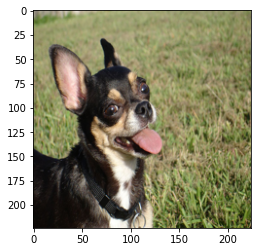

In [94]:
plt.imshow(image)
plt.show()

In [95]:
image = np.reshape(image, (1, 224, 224, 3))

In [96]:
prediction = model.predict(image)
prediction.shape

(1, 37)

In [97]:
pred_class = np.argmax(prediction, axis=-1)
pred_class

array([17])

In [101]:
int(pred_class)

17

In [102]:
class_list[int(pred_class)]

'chihuahua'